# BUSI/COMP 488 Final Project
### *Spring 2023*
### **Team 2**: Amit Parikh, Kunal Pathak, Shiva Kammala, Sanjeev Musuvathy, Olivia Bettis, Ira Chandramouli

# Connect Drive

In [188]:
# Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the folder where the files for the final project are:
%cd /content/drive/MyDrive/488 Final Project/

# See what is in the folder: Special shell command to view the files in the current directory of the notebook environment
!ls 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/School/BUSI-488/488 Final Project
Data  Final_project_G2.ipynb  Ideas.gdoc


# Install and Import Packages

### Installs

In [189]:
!pip install -q -U sentence-transformers

### Imports

In [190]:
# General
import warnings
import re

# Clustering Analysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Text Analysis
from sentence_transformers import SentenceTransformer, util
import torch

# Data Wrangling 
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
sns.set_style("white")

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

# Pull actual Amazon product reviews using Apify

We looked at:

* 8 sponsored URLs (type 1)
* 5 Amazon storefront URLs (type 2)
* 25 general URLs (type 3)

We entered the search term: "Sensodyne Toothpaste" and sorted by featured products. We sorted by featured to get the best representation of products that are showed to consumers when they search on Amazon. We searched in an incognito browser to avoid any targeted advertising. 

In [191]:
# Read in apify data - each URL's reviews are saved in a different csv
df_list = []
# Sponsored listings
for i in range(1,9):
  df_ = pd.read_csv(f'Data/Sponsored/sponsored-url-{i}.csv')
  df_['Type'] = "sponsored"
  df_['URL_ID'] = f'sponsored-url-{i}'
  df_list.append(df_)
# Amazon Storefront listings
for i in range(1,6):
  df_ = pd.read_csv(f'Data/Storefront/storefront-url-{i}.csv')
  df_['Type'] = "storefront"
  df_['URL_ID'] = f'storefront-url-{i}'
  df_list.append(df_)
# General Listings
df_ = pd.read_csv('Data/General/general-url.csv')
df_['Type'] = "general"
df_['URL_ID'] = 'general-url'
df_list.append(df_)

# Concat into one df
df_apify = pd.concat(df_list)
df_apify = df_apify[['date', 'ratingScore', 'reviewDescription', 'Type', 'URL_ID']]

Now, let's find the displeased customers, and try to determine what they are unhappy about.

In [192]:
# Clean data
df_apify['date'] = pd.to_datetime(df_apify['date'])
# Filter to low ratings - 1 and 2 stars
df_apify_low = df_apify[df_apify['ratingScore'].isin([1,2])]

### Let's cluster these displeased customers to see the main reasons why they are unhappy with their purchase.

**Attribution:** The code for embedding and clustering is based on BUSI/COMP 488 Class 24. 

In [193]:
# Load a pre-trained SBERT model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [194]:
# Convert product reviews into latent feature vectors using SBERT
if torch.cuda.is_available()==True:
  print("Embedding on GPU\n")
product_embeddings = embedder.encode(df_apify_low['reviewDescription'].tolist(), batch_size=64, show_progress_bar=True, convert_to_tensor=True)

# Move embeddings from GPU to CPU
if torch.cuda.is_available()==True:
  print("Moving Embeddings from GPU to CPU\n")
  product_embeddings=product_embeddings.cpu()

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [195]:
# Instantiate PCA model for 30 dimensions 
pca = PCA(n_components=30, random_state=42)

# Fit the PCA model to our latent feature vectors
embed_arr = np.array(product_embeddings).tolist()
PCA_result = pca.fit_transform(embed_arr)

# Check new vector length for first vector
print(f'New latent feature vectors have {len(PCA_result[0])} dimensions')

df_apify_low['latent_vector'] = embed_arr

New latent feature vectors have 30 dimensions


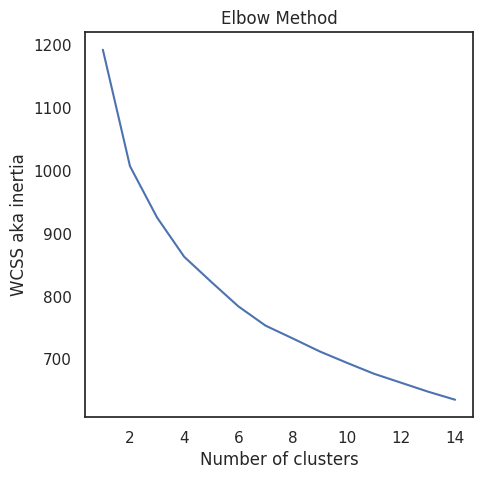

In [196]:
# Create an array to capture inertia (aka within cluster sum of squares) from k-Means clustering
wcss = []
k_range = range(1, 15)

# Cluster for various k
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(PCA_result)
    wcss.append(kmeans.inertia_)

# Plot Elbow Chart
plt.plot(k_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS aka inertia')
plt.show()

There is no clear elbow (common in text analysis), let's use k = 3

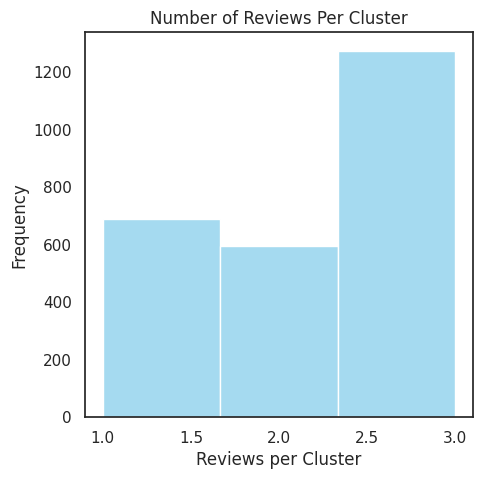

In [197]:
# let's divide the reviews into 3 groups
k=3

# Cluster with K-Means
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(embed_arr)+1

# Add Topic to Results
df_apify_low['Topic'] = pred_y

# Create Histogram
ax = sns.histplot(pred_y,
                  bins=k,
                  kde=False,
                  color='skyblue')
ax.set(xlabel='Reviews per Cluster', ylabel='Frequency', title='Number of Reviews Per Cluster')
plt.show()

In [198]:
# Instantiate and Fit t-SNE
X_tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=50, init='random', random_state=42).fit_transform(PCA_result)

# Add X,Y Coordinates into tweets DataFrame
df_apify_low['tSNE_X'] = np.nan
df_apify_low['tSNE_Y'] = np.nan
df_apify_low.update(pd.DataFrame(X_tsne, columns = ['tSNE_X','tSNE_Y'], index = df_apify_low.index))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2558 samples in 0.001s...
[t-SNE] Computed neighbors for 2558 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2558
[t-SNE] Computed conditional probabilities for sample 2000 / 2558
[t-SNE] Computed conditional probabilities for sample 2558 / 2558
[t-SNE] Mean sigma: 0.240576
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.203995
[t-SNE] KL divergence after 1000 iterations: 0.849910


### Visualize the clusters

In [199]:
source = pd.DataFrame(
    {'x': df_apify_low['tSNE_X'],
     'y': df_apify_low['tSNE_Y'],
     'txt': df_apify_low['reviewDescription'],
     'Topic' : df_apify_low['Topic']
    })

# Define Bubbles on Map
bubbles = alt.Chart(source).mark_circle().encode(
    x=alt.X('x:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),scale=alt.Scale(domain=[min(source.x)-10, max(source.x)+20])),
    y=alt.Y('y:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),scale=alt.Scale(domain=[min(source.y)-10, max(source.y)+10])),
    #size='Relevance:Q',
    color = alt.Color('Topic:N', scale=alt.Scale(scheme='tableau20')),     #  More color schemes at  https://vega.github.io/vega/docs/schemes/
    tooltip=[alt.Tooltip('txt', title='reviewDescription'),                            # We can include a lot of information in the tooltips (mouseover pop-up)
             alt.Tooltip('Topic', title='Topic')
            ]
)

# Visualizes tweets in an interactive Map
bubbles.encode(text='txt').interactive().properties(height=700,width=700,title="Negative Reviews")

alt.Chart(...)

**Reviews in cluster 1 primarily alledge that the Sensodyne products they bought are counterfeit. This is a huge problem on Amazon as a whole, so we will investigate if it is a big threat to Sensodyne's business.**

We will do this by creating a classifier to predict which negative reviews alledge a fake product.

# Read in Generated Reviews from ChatGPT

We used ChatGPT to create reviews (training data) for the two different classes that we are predicting between:


1.   Reviews alleging the sold product is fake and not real Sensodyne toothpaste.
2.   Reviews that are displeased with the Sensodyne product for other reasons.

This assumes that consumers write differently when they are being ripped off as opposed to just being dissatisfied with the product. In reality, many consumers may not know when they are being sold a fake product, so they may write about the product being bad when it is not a real Sensodyne product.



### Read in Reviews from text files

In [200]:
# Read in data from text files
fakeproduct_reviews = open("Data/ChatGPT_Fake_Reviews.txt", "r")
negativeproduct_reviews = open("Data/ChatGPT_Negative_Reviews.txt", "r")

# The Target column will be 1 if it represents a review about a fake product and a 0 if it represents a displeased review for other reasons
reviews_dict = {'Review': [], 'Target': []}

# Loop through reviews about a fake product
for review in fakeproduct_reviews.readlines():
    reviews_dict['Review'].append(re.findall(r'"(.*?)"', review)[0])
    reviews_dict['Target'].append(1)

# Loop through reviews displeased for other reasons 
for review in negativeproduct_reviews:
  reviews_dict['Review'].append(re.findall(r'"(.*?)"', review)[0])
  reviews_dict['Target'].append(0)

df_reviews = pd.DataFrame.from_dict(reviews_dict)

In [201]:
# Make sure classes are relatively balanced
df_reviews['Target'].value_counts()

1    101
0     99
Name: Target, dtype: int64

In [202]:
# Format of df
df_reviews.sample(5)

,Review,Target
136,The taste of this toothpaste is terrible. I co...,0
17,This toothpaste doesn't seem to be working as ...,1
133,I don't think this toothpaste is worth the pri...,0
179,I was disappointed that this toothpaste didn't...,0
190,"I've been using Crest for years, and after try...",0


# Train different classifiers

**Attribution:** The code to train embed our amazon reviews and train our logistic regression model was adapted from BUSI/COMP 488 lecture 24 with Dr. Daniel Ringel. 

### Embed training reviews with SBERT

In [203]:
# Now we can easily embed them with SBERT
if torch.cuda.is_available()==True:
  print("Embedding on GPU\n")
train_embeddings = embedder.encode(df_reviews['Review'].tolist(), batch_size=64, show_progress_bar=True, convert_to_tensor=True)

# Move embeddings from GPU to CPU IF you are using a GPU!
if torch.cuda.is_available()==True:
  print("Moving Embeddings from GPU to CPU\n")
  train_embeddings=train_embeddings.cpu()

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [204]:
# Creates a dataframe with the latent feature vectors of our train reviews
df_latent = pd.DataFrame(train_embeddings) 
df_latent['Target'] = df_reviews['Target'].tolist()

In [205]:
# First, get the labels
y_train = df_latent['Target']

# Second, get the feature vectors
X_train = df_latent.drop(columns='Target')

### Logistic Regression Classifier

In [206]:
# Logistic Regression on Latent Features from Chat GPT generated reviews
LR = LogisticRegression(C=.9) 

# Fit the Classifier to the training data
LR.fit(X_train, y_train)

LogisticRegression(C=0.9)

### SVM Classifier

In [207]:
# SVM Classifier on Latent Features from Chat GPT generated reviews
clf = svm.SVC(C=10, gamma = 0.1)

# Fit the Classifier to the training data
clf.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

### KNN Classifier

In [208]:
# KNN Classifier on Latent Features from Chat GPT generated reviews
neigh = KNeighborsClassifier(n_neighbors=3)

# Fit the Classifier to the training data
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

## Test on [real Amazon review data](https://www.amazon.com/Sensodyne-Pronamel-Whitening-Strengthening-Toothpaste/dp/B0762LYFKP/ref=cm_cr_arp_d_product_top?ie=UTF8) to pick the best classifier

Now that we have trained our model on reviews generated by ChatGPT, we will test our model on reviews from an actual Amazon listing that we have manually classified. 

### Read in Test Data

In [209]:
# Test data 
df_test = pd.read_csv('Data/Real Amazon Test Reviews.csv')

# Embed test data with SBERT
if torch.cuda.is_available()==True:
  print("Embedding on GPU\n")
test_embeddings = embedder.encode(df_test['Review'].tolist(), batch_size=64, show_progress_bar=True, convert_to_tensor=True)

# Move embeddings from GPU to CPU IF you are using a GPU!
if torch.cuda.is_available()==True:
  print("Moving Embeddings from GPU to CPU\n")
  test_embeddings=test_embeddings.cpu()

y_test = df_test['Label']
X_test = test_embeddings

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### Compare Accuracies of the 3 models

In [210]:
# Predict using each model
y_pred_LR = LR.predict(X_test)
y_pred_SVM = clf.predict(X_test)
y_pred_KNN = neigh.predict(X_test)

# Print accuracies
print(f"The Logistic Regression accuracy is {accuracy_score(y_test, y_pred_LR)}")
print(f"The SVM accuracy is {accuracy_score(y_test, y_pred_SVM)}")
print(f"The KNN accuracy is {accuracy_score(y_test, y_pred_KNN)}")

The Logistic Regression accuracy is 0.88
The SVM accuracy is 0.88
The KNN accuracy is 0.9


### Tune the hyperparameters for the KNN model

In [211]:
# defining parameter range
param_grid = {'n_neighbors': list(range(1, 31))} 
  
best_model = GridSearchCV(neigh, param_grid, refit = True, verbose = -1)
  
# fitting the model for grid search
best_model.fit(X_train, y_train)

# print best parameter after tuning
print(best_model.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(best_model.best_estimator_)

{'n_neighbors': 2}
KNeighborsClassifier(n_neighbors=2)


              precision    recall  f1-score   support

           0       0.92      0.97      0.94        34
           1       0.93      0.81      0.87        16

    accuracy                           0.92        50
   macro avg       0.92      0.89      0.90        50
weighted avg       0.92      0.92      0.92        50



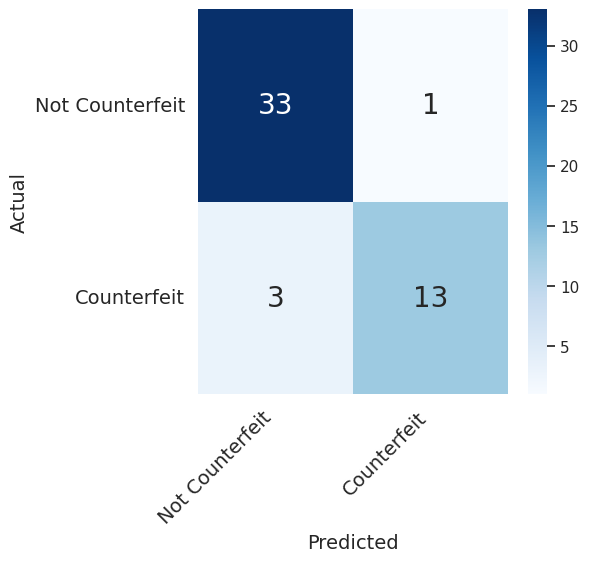

In [212]:
# Visualize the confusion matrix to make it easier to read
%matplotlib inline

# Get Predicitions for training data
y_pred = best_model.predict(X_test)

# Generate confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Not Counterfeit', 'Counterfeit'), ('Not Counterfeit', 'Counterfeit'))

# Visualize
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print Classification Report
print(classification_report(y_test, y_pred))

# Classify Amazon reviews as being about a counterfeit product or not

In [213]:
# Classify reviews as counterfeit or not
df_apify_low['Counterfeit?'] = best_model.predict(product_embeddings)

In [214]:
# How many reviews are classified as counterfeit vs
df_apify_low['Counterfeit?'].value_counts()

0    1718
1     840
Name: Counterfeit?, dtype: int64

In [215]:
# What percent of low reviews for each product are about the product being counterfeit?
low_reviews_per_product = df_apify_low.groupby('Type')['Counterfeit?'].count().reset_index()
counterfeit_reviews_per_product = df_apify_low.groupby('Type')['Counterfeit?'].sum().reset_index()
df_product_breakdown = counterfeit_reviews_per_product.merge(low_reviews_per_product, on ='Type').rename(columns={'Counterfeit?_x': 'NumCounterfeit', 'Counterfeit?_y': 'NumTotal'})
df_product_breakdown['pct_counterfeit'] = df_product_breakdown['NumCounterfeit'] / df_product_breakdown['NumTotal']
df_product_breakdown

,Type,NumCounterfeit,NumTotal,pct_counterfeit
0,general,557,1774,0.313980
1,sponsored,268,734,0.365123
2,storefront,15,50,0.300000


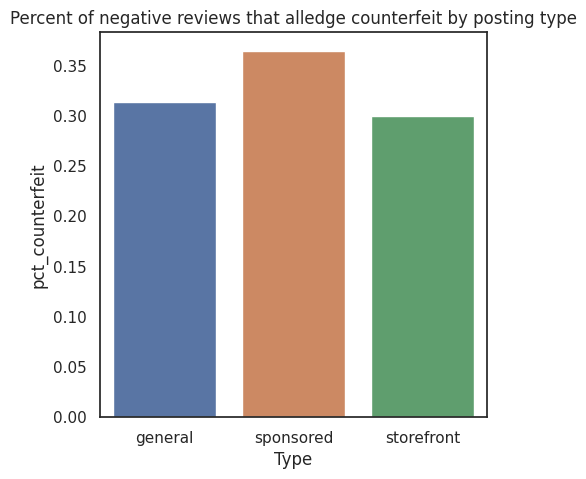

In [216]:
sns.barplot(data=df_product_breakdown, x='Type', y='pct_counterfeit')
plt.title("Percent of negative reviews that alledge counterfeit by posting type")

plt.show()

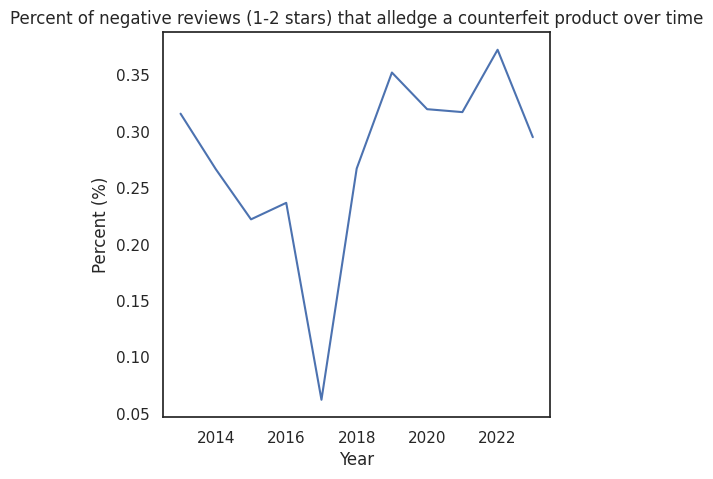

In [217]:
# Track counterfeits over time 
df_apify_low['YEAR'] = df_apify_low['date'].dt.year
counterfeit_reviews_by_year = df_apify_low.groupby('YEAR')['Counterfeit?'].sum().reset_index()
total_bad_reviews_by_year = df_apify_low.groupby('YEAR')['Counterfeit?'].count().reset_index()

df_overtime = counterfeit_reviews_by_year.merge(total_bad_reviews_by_year, on ='YEAR').rename(columns={'Counterfeit?_x': 'NumCounterfeit', 'Counterfeit?_y': 'NumTotal'})
df_overtime['pct_counterfeit'] = df_overtime['NumCounterfeit'] / df_overtime['NumTotal']
sns.lineplot(data=df_overtime, x='YEAR', y='pct_counterfeit')
plt.title("Percent of negative reviews (1-2 stars) that alledge a counterfeit product over time")
plt.ylabel("Percent (%)")
plt.xlabel("Year")
plt.show()

### For negative reviews that do not alledge counterfeit, what are the other main reasons?

We suspect that some negative reviews may not alledge a counterfeit product, but the customers may still be experiencing a counterfeit product unknowingly. If this is the case, the counterfeit is tarnishing Sensodyne's brand reputation.

In [218]:
# Filter to reviews not classified as being about counterfeit
df_not_counterfeit = df_apify_low[df_apify_low['Counterfeit?'] == 0]

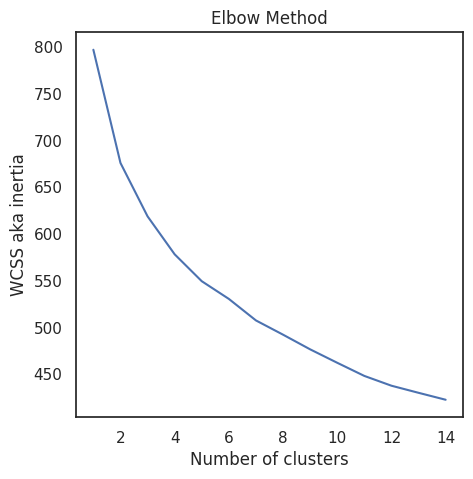

In [219]:
# Create an array to capture inertia (aka within cluster sum of squares) from k-Means clustering
wcss = []
k_range = range(1, 15)

# Cluster for various k
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    #kmeans.fit(tweets.TweetVectors.to_list())
    embed_arr = df_not_counterfeit['latent_vector'].tolist()
    PCA_result = pca.fit_transform(embed_arr)
    kmeans.fit(PCA_result)
    wcss.append(kmeans.inertia_)

# Plot Elbow Chart
plt.plot(k_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS aka inertia')

plt.show()

[Text(0.5, 0, 'Reviews per Cluster'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Number of Reviews Per Cluster')]

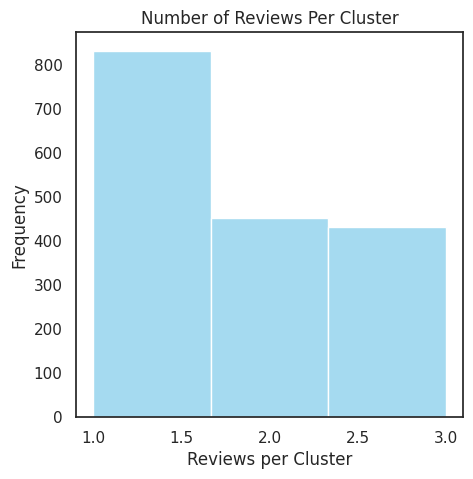

In [220]:
# let's divide the reviews into k groups
k=3

# Cluster with K-Means
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(embed_arr)+1
#pred_y = kmeans.fit_predict(PCA_result)+1

# Add Topic to Results
df_not_counterfeit['Topic'] = pred_y

# Create Histogram
ax = sns.histplot(pred_y,
                  bins=k,
                  kde=False,
                  color='skyblue')
ax.set(xlabel='Reviews per Cluster', ylabel='Frequency', title='Number of Reviews Per Cluster')


In [221]:
# Instantiate and Fit t-SNE
#X_tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=50, init='random', random_state=42).fit_transform(tweets.TweetVectors.to_list())
X_tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=50, init='random', random_state=42).fit_transform(PCA_result)

# Add X,Y Coordinates into tweets DataFrame
df_not_counterfeit['tSNE_X'] = np.nan
df_not_counterfeit['tSNE_Y'] = np.nan
df_not_counterfeit.update(pd.DataFrame(X_tsne, columns = ['tSNE_X','tSNE_Y'], index = df_not_counterfeit.index))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1718 samples in 0.001s...
[t-SNE] Computed neighbors for 1718 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1718
[t-SNE] Computed conditional probabilities for sample 1718 / 1718
[t-SNE] Mean sigma: 0.254910
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.675323
[t-SNE] KL divergence after 1000 iterations: 0.735246


### Visualize the clusters

In [222]:
source = pd.DataFrame(
    {'x': df_not_counterfeit['tSNE_X'],
     'y': df_not_counterfeit['tSNE_Y'],
     'txt': df_not_counterfeit['reviewDescription'],
     'Topic' : df_not_counterfeit['Topic']
    })

# Define Bubbles on Map
bubbles = alt.Chart(source).mark_circle().encode(
    x=alt.X('x:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),scale=alt.Scale(domain=[min(source.x)-10, max(source.x)+20])),
    y=alt.Y('y:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),scale=alt.Scale(domain=[min(source.y)-10, max(source.y)+10])),
    #size='Relevance:Q',
    color = alt.Color('Topic:N', scale=alt.Scale(scheme='tableau20')),     #  More color schemes at  https://vega.github.io/vega/docs/schemes/
    tooltip=[alt.Tooltip('txt', title='reviewDescription'),                            # We can include a lot of information in the tooltips (mouseover pop-up)
             alt.Tooltip('Topic', title='Topic')
            ]
)

# Visualizes tweets in an interactive Map
bubbles.encode(text='txt').interactive().properties(height=700,width=700,title="Negative Reviews")

alt.Chart(...)

Topic 2 primarily consists of reviews mentioning terrible taste.​
This could be a problem with Sensodyne's product **OR it could be that customers are unknowingly getting counterfeit products.​**